

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 5 columns):
imdb         2635 non-null float64
metascore    2635 non-null int64
movie        2635 non-null object
votes        2635 non-null int64
year         2635 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 103.0+ KB
None




,movie,year,imdb,metascore,votes,n_imdb
0,Gladiator,2000,8.5,67,1086642,85.0
1,Memento,2000,8.5,80,934309,85.0
2,Snatch,2000,8.3,55,657875,83.0
3,Requiem for a Dream,2000,8.3,68,633662,83.0
4,X-Men,2000,7.4,64,494999,74.0
5,Cast Away,2000,7.8,73,431922,78.0
6,American Psycho,2000,7.6,64,393035,76.0
7,Unbreakable,2000,7.2,62,282040,72.0
8,Meet the Parents,2000,7.0,73,276182,70.0
9,Mission: Impossible II,2000,6.1,59,261448,61.0


,movie,year,imdb,metascore,votes,n_imdb
1326,The Dark Knight,2008,9.0,82,1848481,90.0
494,The Lord of the Rings: The Return of the King,2003,8.9,94,1338502,89.0
1657,Inception,2010,8.8,74,1638189,88.0
161,The Lord of the Rings: The Fellowship of the Ring,2001,8.8,92,1358829,88.0
328,Cidade de Deus,2002,8.7,79,583118,87.0
325,The Lord of the Rings: The Two Towers,2002,8.7,88,1211829,87.0
1782,Senna,2010,8.6,79,49716,86.0
1827,The Intouchables,2011,8.6,57,583709,86.0
2318,Interstellar,2014,8.6,74,1104871,86.0
1490,Dear Zachary: A Letter to a Son About His Father,2008,8.6,82,25527,86.0


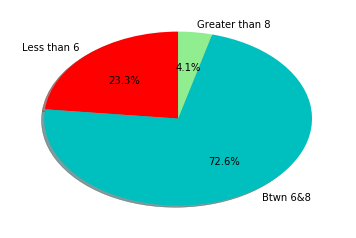

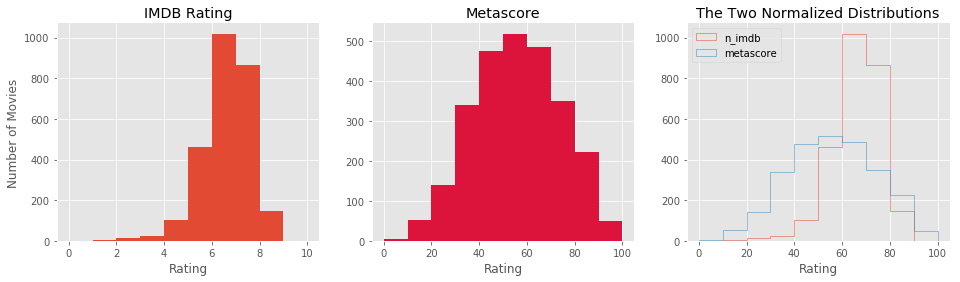

In [1]:

# coding: utf-8

# In[18]:

# -*- coding: utf-8 -*-
"""
Created on Sun Sep 24 16:39:22 2017

@author: Varun Goel
"""
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib import style
from requests import get
from warnings import warn
from time import time
from time import sleep
from random import randint
from IPython.core.display import clear_output, display
from collections import defaultdict
style.use('ggplot')

url = 'http://www.imdb.com/search/title?release_date=2017&sort=num_votes,desc&page=1'
response = get(url)
#print(response.text[:500])

html_soup = BeautifulSoup(response.text, 'lxml')
print(type(html_soup))

# Redeclaring the lists to store data in
names = []
years = []
imdb_ratings = []
metascores = []
votes = []


pages = [str(i) for i in range(1,5)]
years_url = [str(i) for i in range(2000,2016)]

# Preparing the monitoring of the loop
start_time = time()
requests = 0

# For every year in the interval 2000-2017
for year_url in years_url:
    
    # For every page in the interval 1-4
    for page in pages:
        
        # Make a get request
        response = get('http://www.imdb.com/search/title?release_date=' + year_url + 
        '&sort=num_votes,desc&page=' + page,)
        
        # Pause the loop
        sleep(randint(2,4))
        
        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        clear_output(wait = True)
              
        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))
              
        # Break the loop if the number of requests is greater than expected
        if requests > 72:
            warn('Number of requests was greater than expected.')  
        
        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')
        
        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
        
        # For every movie of these 50
        for container in mv_containers:
            # If the movie has a Metascore, then:
            if container.find('div', class_ = 'ratings-metascore') is not None:
                
                # Scrape the name
                name = container.h3.a.text
                names.append(name)
                
                # Scrape the year 
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append(year)

                # Scrape the IMDB rating
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)

                # Scrape the Metascore
                m_score = container.find('span', class_ = 'metascore').text
                metascores.append(int(m_score))
               
               # Scrape the number of votes
                vote = container.find('span', attrs = {'name':'nv'})['data-value']
                votes.append(int(vote))
                
              
print("\n")              
movie_ratings = pd.DataFrame({'movie': names,
                       'year': years,
                       'imdb': imdb_ratings,
                       'metascore': metascores,
                       'votes': votes})
    
print(movie_ratings.info())
print("\n")                
#print(movie_ratings.head(10)) 
#print("\n")                

#CLEANING PHASE
#Reordering the columns
movie_ratings = movie_ratings[['movie', 'year', 'imdb', 'metascore', 'votes']]
#print(movie_ratings.head())

#Converting year from object to integer
movie_ratings.loc[:, 'year'] = movie_ratings['year'].str[-5:-1].astype(int)
#print(movie_ratings['year'].head(3))       

#Min and Max of imdb and scaling them
movie_ratings.describe().loc[['min', 'max'], ['imdb', 'metascore']]
movie_ratings['n_imdb'] = movie_ratings['imdb'] * 10
display(movie_ratings.head(10))

#Saving to csv
movie_ratings.to_csv('movie_ratings.csv')

print("\n")
mov_rat = movie_ratings.sort_values('imdb', ascending=False)
display(mov_rat.head(10))

rating = defaultdict(dict)
rating['Less than 6'] = movie_ratings[(movie_ratings['imdb']<6)]['imdb'].count()
rating['Btwn 6&8'] = movie_ratings[(movie_ratings['imdb']>=6) & (movie_ratings['imdb']<8)]['imdb'].count()
rating['Greater than 8'] = movie_ratings[(movie_ratings['imdb']>8)]['imdb'].count()


#Plotting on Matplotlib
#get_ipython().magic('matplotlib inline')

rating_hist = []

rating_hist.append(rating['Less than 6'])
rating_hist.append(rating['Btwn 6&8'])
rating_hist.append(rating['Greater than 8'])

labels = ['Less than 6', 'Btwn 6&8', 'Greater than 8']
colors = ['red', 'c', 'lightgreen']

plt.pie(rating_hist, labels=labels, colors=colors, autopct= '%1.1f%%', shadow=True, startangle=90)
plt.figure(figsize=(10,8))

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,4))
ax1, ax2, ax3 = fig.axes

ax1.hist(movie_ratings['imdb'], bins = 10, range = (0,10)) # bin range = 1
ax1.set_title('IMDB Rating')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Number of Movies')

ax2.hist(movie_ratings['metascore'], color = 'Crimson', bins = 10, range = (0,100)) # bin range = 10
ax2.set_title('Metascore')
ax2.set_xlabel('Rating')


ax3.hist(movie_ratings['n_imdb'], bins = 10, range = (0,100), histtype = 'step')
ax3.hist(movie_ratings['metascore'], bins = 10, range = (0,100), histtype = 'step')
ax3.legend(loc = 'upper left')
ax3.set_title('The Two Normalized Distributions')
ax3.set_xlabel('Rating')

for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.savefig('imdb.png')    
plt.show()
                






